In [ ]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent   
sys.path.insert(0, str(PROJECT_ROOT))

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.data import read_xyz_trajectory, split_dataset, prepare_data, prepare_model_dataset, standardize_X_train_apply, build_bp_tensors
from src.feature_builders import add_pairwise_distance_features, build_proton_transfer_features, add_acsf_columns 
from src.model import make_atomic_nn, BPHDNNP

In [2]:
DATA_DIR = "../dataset/"

In [3]:
dataset = read_xyz_trajectory(os.path.join(DATA_DIR, "raw/malonaldehyde_300K/structures.xyz"), os.path.join(DATA_DIR, "raw/malonaldehyde_300K/energies.txt"))
test_dataset_unprepared = read_xyz_trajectory(os.path.join(DATA_DIR, "raw/malonaldehyde_300K-test/structures.xyz"), os.path.join(DATA_DIR, "raw/malonaldehyde_300K-test/energies.txt"))
    

train_dataset_unprepared, val_dataset_unprepared = split_dataset(dataset, val_size=0.1, random_state=42)
train_dataset_unprepared.head(15)

,frame,atom_index,element,atomic_number,x,y,z,energy
0,0,0,O,8,7.518784,12.374943,9.872595,-44957.131360
1,0,1,C,6,7.700793,10.111345,10.143338,-44957.131360
2,0,2,C,6,10.074552,8.697429,9.988165,-44957.131360
3,0,3,C,6,12.301752,9.908006,9.874942,-44957.131360
4,0,4,O,8,12.404117,12.447734,10.120959,-44957.131360
5,0,5,H,1,5.978652,8.981591,10.231535,-44957.131360
6,0,6,H,1,9.954607,6.692762,9.916954,-44957.131360
7,0,7,H,1,14.156946,8.958377,9.833734,-44957.131360
8,0,8,H,1,10.442674,12.790426,9.943805,-44957.131360
9,1,0,O,8,7.641590,12.480086,9.958507,-44958.579728


#### High-Dimensional Neural Networks as Proposed by Behler et.al

In [5]:
# 1) Build descriptor columns (radial+angular, element-resolved)
train_dataset, acsf_cols, element_types = add_acsf_columns(train_dataset_unprepared, R_cut=5.5, prefix="ACSF")
val_dataset,   _,        _             = add_acsf_columns(val_dataset_unprepared,   R_cut=5.5, prefix="ACSF")
test_dataset,  _,        _             = add_acsf_columns(test_dataset_unprepared,  R_cut=5.5, prefix="ACSF")


E:\AppData\Temp\ipykernel_6680\3565107906.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c] = np.nan
E:\AppData\Temp\ipykernel_6680\3565107906.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c] = np.nan
E:\AppData\Temp\ipykernel_6680\3565107906.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

In [6]:
train_dataset.describe()

,frame,atom_index,atomic_number,x,y,z,energy,ACSF_G2_C_0,ACSF_G2_C_1,ACSF_G2_C_2,...,ACSF_G4_O-O_2,ACSF_G4_O-O_3,ACSF_G4_O-O_4,ACSF_G4_O-O_5,ACSF_G4_O-O_6,ACSF_G4_O-O_7,ACSF_G4_O-O_8,ACSF_G4_O-O_9,ACSF_G4_O-O_10,ACSF_G4_O-O_11
count,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,...,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000
mean,996.356111,4.000000,4.222222,9.999355,10.108853,10.000970,-44953.982464,0.529147,0.629367,0.705678,...,0.057361,0.001646,0.051446,0.000687,0.051701,0.004395,0.048578,0.001273,0.043600,0.000524
std,578.178617,2.582069,2.973222,2.506490,1.952953,0.199188,3.546621,0.148121,0.166695,0.176716,...,0.163816,0.003031,0.148912,0.001440,0.145960,0.008812,0.139041,0.002316,0.126440,0.001096
min,0.000000,0.000000,1.000000,5.619141,6.493508,8.612501,-44961.645867,0.112821,0.150628,0.189234,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,495.750000,2.000000,1.000000,7.649608,8.816977,9.917692,-44956.393865,0.419604,0.502376,0.567900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,998.500000,4.000000,6.000000,9.999796,9.940439,10.000539,-44954.527769,0.521608,0.613794,0.680484,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1494.250000,6.000000,6.000000,12.351546,12.366895,10.082070,-44952.053084,0.649719,0.754168,0.825379,...,0.000718,0.001757,0.000067,0.000421,0.001855,0.004252,0.000557,0.001411,0.000052,0.000324
max,1999.000000,8.000000,8.000000,14.394796,13.537416,11.301125,-44928.723831,0.811236,0.960118,1.068319,...,0.745218,0.017338,0.732365,0.008247,0.652443,0.072303,0.646792,0.014311,0.635636,0.006398


In [7]:
train_dataset.columns

Index(['frame', 'atom_index', 'element', 'atomic_number', 'x', 'y', 'z',
       'energy', 'ACSF_G2_C_0', 'ACSF_G2_C_1',
       ...
       'ACSF_G4_O-O_2', 'ACSF_G4_O-O_3', 'ACSF_G4_O-O_4', 'ACSF_G4_O-O_5',
       'ACSF_G4_O-O_6', 'ACSF_G4_O-O_7', 'ACSF_G4_O-O_8', 'ACSF_G4_O-O_9',
       'ACSF_G4_O-O_10', 'ACSF_G4_O-O_11'],
      dtype='object', length=224)

In [9]:
X_train, Z_train, y_train, elem_to_id = build_bp_tensors(train_dataset, feature_cols=acsf_cols, element_types=element_types)
X_val,   Z_val,   y_val,   _          = build_bp_tensors(val_dataset,   feature_cols=acsf_cols, element_types=element_types)
X_test,  Z_test,  y_test,  _          = build_bp_tensors(test_dataset,  feature_cols=acsf_cols, element_types=element_types)

print("Shapes:", X_train.shape, Z_train.shape, y_train.shape, elem_to_id)

Shapes: (1800, 9, 216) (1800, 9) (1800,) {'C': 0, 'H': 1, 'O': 2}


In [10]:
print(X_train)

[[[5.1608145e-01 6.0558248e-01 6.6936111e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.5923147e-01 4.3698457e-01 5.0042009e-01 ... 2.2358275e-03
   4.7074376e-05 1.0484353e-03]
  [7.4382693e-01 8.8762504e-01 9.9588984e-01 ... 5.4178461e-03
   9.2997652e-05 2.6370788e-03]
  ...
  [7.2156453e-01 8.4775072e-01 9.4056600e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [6.1776769e-01 7.1850020e-01 7.8774655e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.3654889e-01 4.3587857e-01 5.3097421e-01 ... 3.3619875e-04
   4.6988964e-01 2.1701518e-07]]

 [[4.4031760e-01 5.2804798e-01 5.9647095e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [4.2799667e-01 5.1153094e-01 5.7564664e-01 ... 4.0905848e-03
   5.2665629e-05 2.0920297e-03]
  [7.5982738e-01 9.0510595e-01 1.0136571e+00 ... 7.5573106e-03
   9.7356162e-05 3.8646262e-03]
  ...
  [6.9947791e-01 8.2510942e-01 9.1895270e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [5.7006377e-01 6.6645348e-01 7.342

In [11]:
print(Z_train)

[[2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 ...
 [2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]]


In [ ]:
X_train_s, X_val_s, X_test_s, X_mean, X_std = standardize_X_train_apply(X_train, X_val, X_test)

In [14]:
y_mean = y_train.mean()
y_std  = y_train.std() + 1e-12
y_train_n = (y_train - y_mean) / y_std
y_val_n   = (y_val   - y_mean) / y_std
y_test_n  = (y_test  - y_mean) / y_std

In [15]:
def stats(name, y):
    print(name, "min", y.min(), "max", y.max(), "std", y.std(), "range", y.max()-y.min())

stats("train", y_train)
stats("val",   y_val)
stats("test",  y_test)


train min -44961.645 max -44928.723 std 3.546503 range 32.921875
val min -44960.293 max -44945.06 std 3.0005493 range 15.234375
test min -44962.023 max -44949.977 std 1.8853621 range 12.046875


In [17]:
# Build + train
n_frames, n_atoms, desc_dim = X_train.shape
n_elements = len(elem_to_id)

model = BPHDNNP(n_elements=n_elements, desc_dim=desc_dim, hidden=(64,64))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse")

In [24]:
model.summary()

Model: "bphdnnp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 nn_elem_0 (Functional)      (None, 1)                 18113     
                                                                 
 nn_elem_1 (Functional)      (None, 1)                 18113     
                                                                 
 nn_elem_2 (Functional)      (None, 1)                 18113     
                                                                 
Total params: 54,339
Trainable params: 54,339
Non-trainable params: 0
_________________________________________________________________


In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.25,
        patience=30,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    (X_train_s, Z_train), y_train_n,
    validation_data=((X_val_s, Z_val), y_val_n),
    epochs=500,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/500
57/57 [==============================] - 1s 5ms/step - loss: 2.0712 - val_loss: 0.6392 - lr: 1.0000e-04
Epoch 2/500
57/57 [==============================] - 0s 2ms/step - loss: 0.7004 - val_loss: 0.4751 - lr: 1.0000e-04
Epoch 3/500
57/57 [==============================] - 0s 2ms/step - loss: 0.5468 - val_loss: 0.3798 - lr: 1.0000e-04
Epoch 4/500
57/57 [==============================] - 0s 2ms/step - loss: 0.4537 - val_loss: 0.3294 - lr: 1.0000e-04
Epoch 5/500
57/57 [==============================] - 0s 2ms/step - loss: 0.3975 - val_loss: 0.3074 - lr: 1.0000e-04
Epoch 6/500
57/57 [==============================] - 0s 2ms/step - loss: 0.3631 - val_loss: 0.2766 - lr: 1.0000e-04
Epoch 7/500
57/57 [==============================] - 0s 2ms/step - loss: 0.3222 - val_loss: 0.2580 - lr: 1.0000e-04
Epoch 8/500
57/57 [==============================] - 0s 2ms/step - loss: 0.2958 - val_loss: 0.2482 - lr: 1.0000e-04
Epoch 9/500
57/57 [==============================] - 0s 2ms/step - loss:

In [19]:
y_pred_n = model.predict((X_test_s, Z_test)).ravel()
y_pred   = y_pred_n * y_std + y_mean

mae  = np.mean(np.abs(y_pred - y_test))
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("MAE:", mae, "RMSE:", rmse)


13/13 [==============================] - 0s 815us/step
MAE: 0.7011621 RMSE: 0.9783825


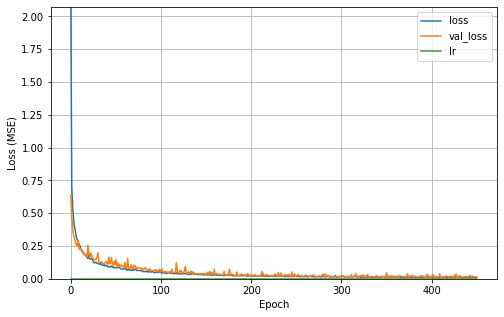

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.show()


13/13 [==============================] - 0s 808us/step


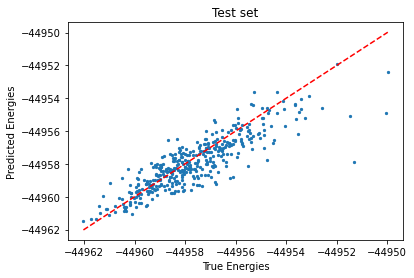

In [21]:
# Predict normalized
y_pred_n = model.predict((X_test_s, Z_test)).ravel()

# De-normalize back to energy units
y_test_energy = y_test  # already raw energies in your current pipeline
y_pred_energy = y_pred_n * y_std + y_mean

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y_test_energy, y_pred_energy, s=5)
plt.plot([y_test_energy.min(), y_test_energy.max()],
         [y_test_energy.min(), y_test_energy.max()], 'r--')
plt.xlabel("True Energies")
plt.ylabel("Predicted Energies")
plt.title("Test set")
plt.show()


In [22]:
from sklearn.metrics import r2_score

err = y_pred_energy - y_test_energy
print("ME (bias):", err.mean())
print("MAE:", np.mean(np.abs(err)))
print("RMSE:", np.sqrt(np.mean(err**2)))
print("R2:", r2_score(y_test_energy, y_pred_energy))



ME (bias): -0.24139649
MAE: 0.7011621
RMSE: 0.9783825
R2: 0.730705283164022


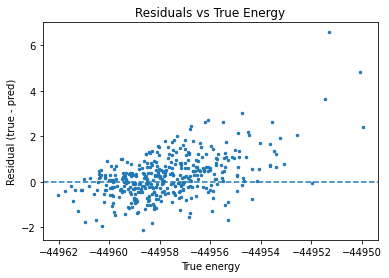

In [23]:
plt.figure()
plt.scatter(y_test_energy, y_test_energy - y_pred_energy, s=6)
plt.axhline(0, linestyle="--")
plt.xlabel("True energy")
plt.ylabel("Residual (true - pred)")
plt.title("Residuals vs True Energy")
plt.show()
